In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE

from IPython.display import display


import warnings
import pickle

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def read_json_df(path):
    json = pd.read_json(r"{}".format(path))
    df_apartments = json[['id', 'floor', 'beds', 'price', 'size_m2']]
    
    df_tags = json.explode('tags').dropna(subset=['tags'])
    df_tags['tag_category'] = df_tags['tags'].apply(lambda x: x['tag_category'])
    df_tags['tag_value'] = df_tags['tags'].apply(lambda x: x['tag_value'])
    
    df_tags = df_tags.pivot_table(index='id',
                                  columns='tag_category', 
                                  values='tag_value', 
                                  aggfunc='first').reset_index()
    
    df = df_apartments.merge(df_tags, on='id', how='left')
    return df


df = read_json_df("for_rent_apartments.json")

features = df.drop("id",axis=1).columns
new_df = df[features]

In [3]:
scaler = pickle.load(open("for_rent_preprocessor.pkl","rb"))
scaled_df = scaler.transform(new_df)

In [4]:
with open('for_rent_clustering_model.pkl', 'rb') as f:
    clustering = pickle.load(f)
    tsne = clustering['tsne']
    kmeans = clustering['kmeans']

In [5]:
tsne_results = tsne.fit_transform(scaled_df)
kmeans.fit(tsne_results)
labels = kmeans.labels_

## User Data Example

In [6]:
df.head(1)

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,ieVNwuOX98B,2,3,10000,70,2.0,1.0,1.0,1.0,2.0,2.0,5.0


In [7]:
user_prefs = pd.DataFrame({
    "floor":[2],
    "beds":[3],
    "price":[6000],
    "size_m2":[80],
    "families":[4],
    "light_trail":[2],
    "parks":[4],
    "quiet_street":[5],
    "religious":[3],
    "school":[4],
    "secular":[3]
})

In [8]:
display(user_prefs)

,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,2,3,6000,80,4,2,4,5,3,4,3


In [9]:
user_prefs_scaled = scaler.transform(user_prefs)
combined_data = np.vstack([scaled_df, user_prefs_scaled])
tsne_combined_results = tsne.fit_transform(combined_data)

tsne_results = tsne_combined_results[:-1]
user_prefs_tsne_results = tsne_combined_results[-1]

kmeans.fit(tsne_results)
labels = kmeans.labels_

user_prefs_label = kmeans.predict(user_prefs_tsne_results.reshape(1, -1))

print("User is in cluster:",user_prefs_label[0])

User is in cluster: 5


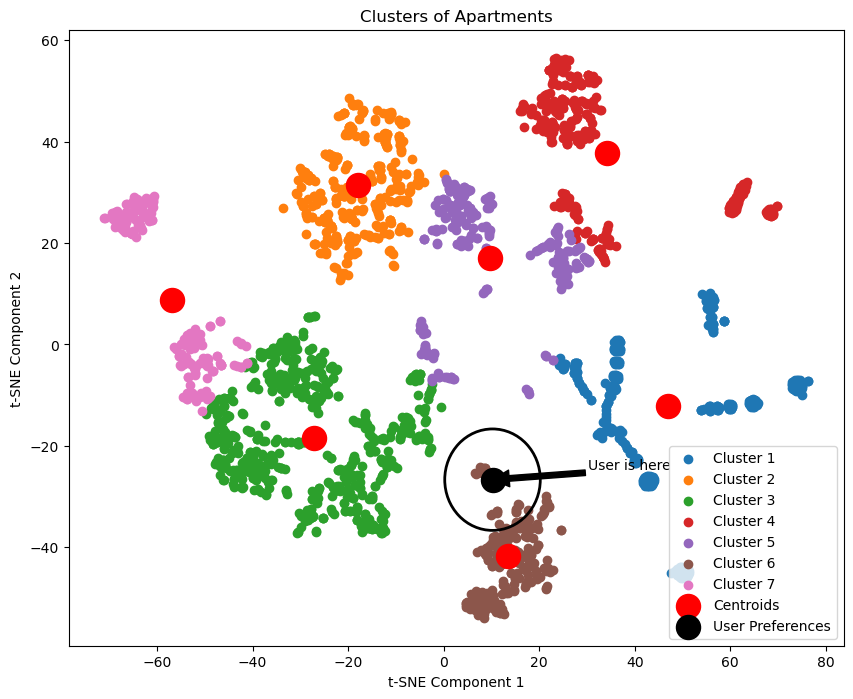

In [10]:
plt.figure(figsize=(10, 8))
for i in range(len(kmeans.cluster_centers_)):
    plt.scatter(tsne_results[labels == i, 0], tsne_results[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')

plt.scatter(user_prefs_tsne_results[0], user_prefs_tsne_results[1], s=300, c='black', label='User Preferences')

circle = plt.Circle((user_prefs_tsne_results[0], user_prefs_tsne_results[1]), 10, color='black', fill=False, linewidth=2)
plt.gca().add_artist(circle)

plt.annotate('User is here',
             xy=(user_prefs_tsne_results[0], user_prefs_tsne_results[1]), 
             xytext=(user_prefs_tsne_results[0] + 20, user_prefs_tsne_results[1] + 2),
             arrowprops=dict(facecolor='black', shrink=5))

plt.title('Clusters of Apartments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import pairwise_distances

# Assuming tsne_combined_results contains the t-SNE results including the user's preferences
user_index = -1  # Index of user's preferences in the combined data
user_tsne_position = tsne_combined_results[user_index]

# Filter apartments in the user's cluster
user_cluster = user_prefs_label[0]
user_cluster_indices = np.where(labels == user_cluster)[0]
cluster_apartments_tsne = tsne_results[user_cluster_indices]

# Calculate Euclidean distances between the user's preferences and each apartment in the cluster
distances = pairwise_distances(cluster_apartments_tsne, user_tsne_position.reshape(1, -1), metric='euclidean').flatten()

# Normalize the distances to get similarity scores (0 means identical, higher values mean less similar)
max_distance = distances.max()
similarity_scores = 1 - (distances / max_distance)

# Create a DataFrame with the original apartment data and similarity scores
cluster_apartments = df.iloc[user_cluster_indices].copy()
cluster_apartments['similarity_score'] = similarity_scores


In [12]:
top_n_apartments = cluster_apartments.nlargest(20, 'similarity_score')

In [13]:
top_n_apartments.nlargest(1,"similarity_score")

,id,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular,similarity_score
1000,eHY5SzMRknd,3,3,127,155,5.0,2.0,4.0,5.0,2.0,2.0,3.0,0.972427


In [14]:
user_prefs

,floor,beds,price,size_m2,families,light_trail,parks,quiet_street,religious,school,secular
0,2,3,6000,80,4,2,4,5,3,4,3


##### Top Apartment Match:

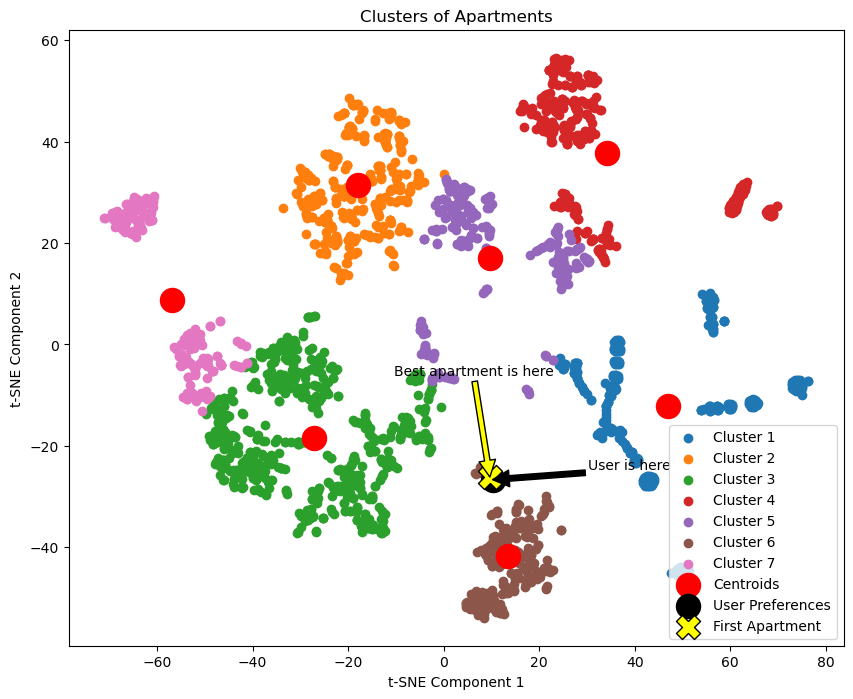

In [15]:
first_apartment_index = top_n_apartments.index[0]
first_apartment_tsne = tsne_results[first_apartment_index]

plt.figure(figsize=(10, 8))
for i in range(len(kmeans.cluster_centers_)):
    plt.scatter(tsne_results[labels == i, 0], tsne_results[labels == i, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')

plt.scatter(user_prefs_tsne_results[0], user_prefs_tsne_results[1], s=300, c='black', label='User Preferences')

# Highlight the first apartment
plt.scatter(first_apartment_tsne[0], first_apartment_tsne[1], s=300, c='yellow', edgecolors='black', label='First Apartment', marker='X')


plt.annotate('User is here',
             xy=(user_prefs_tsne_results[0], user_prefs_tsne_results[1]), 
             xytext=(user_prefs_tsne_results[0] + 20, user_prefs_tsne_results[1] + 2),
             arrowprops=dict(facecolor='black', shrink=5))

plt.annotate('Best apartment is here',
             xy=(first_apartment_tsne[0], first_apartment_tsne[1]), 
             xytext=(first_apartment_tsne[0] -20 , first_apartment_tsne[1] + 20),
             arrowprops=dict(facecolor='yellow', shrink=5))

plt.title('Clusters of Apartments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()